# Simulation and inversion of synthetic muon data,

This notebook illustrates how to use geoh5py with a synthetic tomography problem.

Runs using geoapps=0.4.0

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from geoh5py.workspace import Workspace
from geoh5py.objects import Points, Curve
from discretize.utils import meshutils
from discretize import TreeMesh
from geoapps.utils import treemesh_2_octree
from geoapps.simpegPF import (
    PF,
    DataMisfit,
    Directives,
    Inversion,
    InvProblem,
    Maps,
    Mesh,
    Problem,
    Props,
    Optimization,
    Regularization,
    Survey,
    Utils,
)

## Input

In [18]:
# First connect to the demo geoh5
ws = Workspace(h5file="../../assets/FlinFlon.geoh5")

# Grab the topography surface
topo = ws.get_entity("Topography")[0]

# Create an array of receivers below ground
center = np.mean(topo.vertices, axis=0)
x_locs = np.linspace(center[0]-200, center[0]+200, 8)
y_locs = np.linspace(center[1]-200, center[1]+200, 8)

xgrid, ygrid = np.meshgrid(x_locs, y_locs)
zgrid = np.ones_like(xgrid) * center[2] - 400
receivers = np.c_[xgrid.flatten(), ygrid.flatten(), zgrid.flatten()]

# Add those receivers to ANALYST
pts = Points.create(ws, name='Muon Detectors', vertices=receivers)

In [19]:
# For simplicity, use the nodes of topography
# within some area as pierce points for the muons
ind = (
    (topo.vertices[:, 0] > center[0] - 400) & (topo.vertices[:, 0] < center[0] + 400) &
    (topo.vertices[:, 1] > center[1] - 400) & (topo.vertices[:, 1] < center[1] + 400)
)
entries = topo.vertices[ind, :]

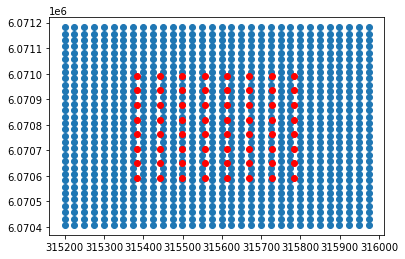

In [20]:
# Quick plot, as seen from above
plt.scatter(entries[:, 0], entries[:, 1])
plt.scatter(receivers[:, 0], receivers[:, 1], c='r')

In [21]:
# Create a random selection between receivers and entries
n_data = 200
rx_ind = np.random.randint(0, high=receivers.shape[0], size=n_data)
in_ind = np.random.randint(0, high=entries.shape[0], size=n_data)

pairs = np.unique(np.c_[rx_ind, in_ind], axis=1) # Could endup with less due to dupliactes
pairs = pairs[np.argsort(pairs[:,0]), :]

# Add the rays as a curve object to ANALYST
cells = pairs.copy()
cells[:, 1] += receivers.shape[0]
rays = Curve.create(ws, name='Muon Rays', vertices=np.r_[receivers, entries], cells=cells.astype("uint32"))

## Create a 3D model space

Here we can use some built-in functions to create an octree mesh from the topo and receivers

In [22]:
core_cell_size = [10, 10, 10]
octree_levels_padding = [1,3]
octree_levels_obs = [10,4]
octree_levels_topo = [0,2] 
padding_distance = [[50, 50], [50, 50], [200, 50]]

mesh = meshutils.mesh_builder_xyz(
    rays.vertices, core_cell_size,
    mesh_type='TREE',
)

mesh = meshutils.refine_tree_xyz(mesh, topo.vertices, octree_levels=[2,10,2], method='surface', finalize=False)
mesh = meshutils.refine_tree_xyz(mesh, receivers, octree_levels=[1], method='surface', finalize=True)

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo.vertices, 'CC')
active = np.zeros(mesh.nC, dtype='bool')
active[actv] = True

actv = Utils.surface2ind_topo(mesh, receivers, 'CC')
active[actv] = False

# Create a SurjectMap for export
active_map = Maps.InjectActiveCells(
        mesh, active, 0,
)

# Create a simple density block
anom = np.c_[
    center-50, center+50
].T
anom[:, 2] -= 200
ind = Utils.ModelBuilder.getIndicesBlock(anom[0,:], anom[1,:], mesh.gridCC)
model = active.copy().astype(float) * 0.1
model[ind] = 0.5

# Write the octree mesh to geoh5
octree = treemesh_2_octree(ws, mesh)
octree.add_data({
    "Active": {"values": actv[mesh._ubc_order].astype(int)},
    "True": {"values": model[mesh._ubc_order]}
})

## Generate data

Now that we have receivers and a model, we can generate some data.

In [23]:
# This is a simple class for linear tomography problems
class TomoProblem(Problem.LinearProblem):
    
    rho, rhoMap, rhoDeriv = Props.Invertible(
        "Density (g\cc)",
        default=0.
    )

    def __init__(self, mesh, **kwargs):
        self._active_cells = None
        self.mesh = mesh
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        
    @property
    def mesh(self):
        return self._mesh
    
    @mesh.setter
    def mesh(self, mesh):
        assert isinstance(mesh, TreeMesh), f"Mesh must be of the {TreeMesh}"
        self._mesh = mesh
        
    @property
    def active_cells(self):
        """
        Active cell vector
        """
        return self._active_cells
    
    @active_cells.setter
    def active_cells(self, active_cells):
        
        assert active_cells.shape[0] == self.mesh.nC, f"Active cells must be of length {mesh.nC}"
        assert active_cells.dtype == 'bool', f"Active cells must be of type bool"
    
        self._active_cells = active_cells
        
    @property
    def G(self):
        if not self.ispaired:
            raise Exception('Need to pair!')

        if getattr(self, '_G', None) is None:
            self._G = self.lineIntegral()

        return self._G
    
    def lineIntegral(self):
        
        # Assign value to F
        F = np.zeros((
            self.survey.nD, 
            int(self.active_cells.sum())
        ))
        
        count = 0
        for tx in self.survey.srcList:
            
            rxLocs = tx.rxList[0].locs.tolist()
            for rx in rxLocs:
                F[count, :] += self.cellPath(tx.loc.flatten(), rx)[self._active_cells]
                
                count += 1
        
        return F
    
    # Compute lengths
    def cellPath(self, tx_locs, rx_locs):

        r = tx_locs - rx_locs
        r /= np.linalg.norm(r)

        x_interceps = np.c_[
            mesh.vectorNx,
            (mesh.vectorNx - rx_locs[0]) / r[0] * r[1] + rx_locs[1],
            (mesh.vectorNx - rx_locs[0]) / r[0] * r[2] + rx_locs[2]
        ]

        y_interceps = np.c_[
            (mesh.vectorNy - rx_locs[1]) / r[1] * r[0] + rx_locs[0],
            mesh.vectorNy,
            (mesh.vectorNy - rx_locs[1]) / r[1] * r[2] + rx_locs[2]
        ]

        z_interceps = np.c_[
            (mesh.vectorNz - rx_locs[2]) / r[2] * r[0] + rx_locs[0],
            (mesh.vectorNz - rx_locs[2]) / r[2] * r[1] + rx_locs[1],
            mesh.vectorNz,

        ]

        faces = np.r_[x_interceps, y_interceps, z_interceps]

        z_sort = np.argsort(faces[:, 2])
        faces = faces[z_sort, :]
        midpoints = (faces[1:, :] + faces[:-1, :]) / 2
        cells = mesh._get_containing_cell_indexes(midpoints).tolist()
        dl = np.linalg.norm(faces[1:, :] - faces[:-1, :], axis=1)

        integral = np.zeros(mesh.nC)
        for ii, cell in enumerate(cells):
            integral[cell] += dl[ii]

        return integral
    
    @property
    def modelMap(self):
        """
            Call for general mapping of the problem
        """
        return self.rhoMap
    
class LinearSurvey(Survey.BaseSurvey):
    """Base Magnetics Survey"""

    rxLoc = None  #: receiver locations
    rxType = None  #: receiver type
    
    def __init__(self, srcList, **kwargs):
        self.srcList = srcList
        Survey.BaseSurvey.__init__(self, **kwargs)
        
    def eval(self, u):
        return u

## Create a simulation and generate data

In [24]:
# Create the problem
prob = TomoProblem(mesh, active_cells = active, rhoMap = Maps.IdentityMap(nP=int(active.sum())))

src = []
midpoints = []
# Create source and receivers
for ii in np.unique(pairs[:, 0]):
    ind = pairs[:, 0] == ii
    
    midpoints += [(receivers[ii, :] + entries[pairs[ind, 1], :])/2]
    rec = [Survey.BaseRx(entries[pairs[ind, 1], :],'rx')]
    src += [Survey.BaseSrc(rec, loc=receivers[ii, :])]
survey = LinearSurvey(src)
survey.pair(prob)

# Generate some data with random noise
error = 5.
d = prob.fields(model[active])
noise = error * np.random.randn(d.shape[0])
survey.dobs = d + noise
survey.std = np.ones_like(d) * error

### Export the data as midpoints

In [25]:
sensitivities = (prob.G**2.).sum(axis=0)**0.5

octree.add_data({  
    "sensitivities": {"values": (active_map * sensitivities)[mesh._ubc_order]},
})

mid_points = Points.create(
    ws, name="Muon_midpoints", vertices=np.vstack(midpoints)
)
data_points = mid_points.add_data({
    "Data_cell": {"values": d}
})

## Run the inversion

In [28]:
# Create reduced identity map
nC = int(active.sum())
idenMap = Maps.IdentityMap(nP=nC)

# Create a regularization
wr = 1./(sensitivities + sensitivities[sensitivities>0].min())
wr /= wr.min()
reg = Regularization.Sparse(mesh, indActive=active, mapping=idenMap, gradientType='component')
# reg.cell_weights = wr
reg.mref = np.ones(nC) * 0.1
reg.norms = np.c_[1, 1, 1, 1]

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-10., upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, betaSearch=False, maxIRLSiter=10, chifact_target=1.)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
inv.run(m0)


=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.06e-01  1.39e+04  3.42e+06  7.17e+05    2.81e+03      0              
   1  1.03e-01  4.40e+02  2.93e+02  4.70e+02    2.08e+02      0              
   2  5.14e-02  3.53e+02  9.17e+02  4.00e+02    1.97e+02      0   Skip BFGS  
   3  2.57e-02  2.44e+02  2.45e+03  3.07e+02    1.78e+02      0   Skip BFGS  
   4  1.29e-02  1.39e+02  5.36e+03  2.08e+02    1.50e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
   5  6.43e-03  6.41e+01  6.41e+04  4.76e+02    6.72e+02      0   Skip BFGS  
   6  4.82e-03  1.40e+02  4.51e+04  3.57e+02    4.54e+02      0              
   7  3.62e-03  1.88e+02  4.17e+04  3.38e+02    2.91e+02      0              
   8  2.71e-03  2.08e+02  4.52e+04  3.31e+02    1

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

### Output the final models and predicted

In [29]:
octree.add_data({  
    "smooth_model": {"values": (active_map * invProb.l2model)[mesh._ubc_order]},
    "compact_model": {"values": (active_map * invProb.model)[mesh._ubc_order]},
})

mid_points.add_data({
    "Predicted2": {"values": invProb.dpred, "entity_type": data_points.entity_type},
    "Residual": {"values": d-invProb.dpred}
    
})